In [140]:
import sys

sys.path.insert(1, '..')
from custom_functions import ModelFunctions

In [141]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.metrics import ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay, accuracy_score, classification_report



In [142]:
df = pd.read_csv('../data/features.csv')

<AxesSubplot:xlabel='Transported', ylabel='count'>

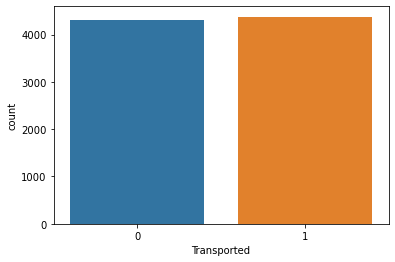

In [143]:
sns.countplot(data=df, x='Transported')

In [144]:
X = df.drop(['Transported', 'LuxurySpend'], axis=1)
y = df.Transported

In [145]:
X

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Europa,HomePlanet_Mars,CabinDeck_B,CabinDeck_C,CabinDeck_D,CabinDeck_E,CabinDeck_F,CabinDeck_G,CabinDeck_T,Destination_PSO J318.5-22,Destination_TRAPPIST-1e
0,0,4,0,0.0,0.0,0.0,0.0,0.0,1,0,1,0,0,0,0,0,0,0,1
1,0,2,0,109.0,9.0,25.0,549.0,44.0,0,0,0,0,0,0,1,0,0,0,1
2,0,6,1,43.0,3576.0,0.0,6715.0,49.0,1,0,0,0,0,0,0,0,0,0,1
3,0,4,0,0.0,1283.0,371.0,3329.0,193.0,1,0,0,0,0,0,0,0,0,0,1
4,0,1,0,303.0,70.0,151.0,565.0,2.0,0,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,0,5,1,0.0,6819.0,0.0,1643.0,74.0,1,0,0,0,0,0,0,0,0,0,0
8689,1,1,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,1,0,1,0
8690,0,3,0,0.0,0.0,1872.0,1.0,0.0,0,0,0,0,0,0,0,1,0,0,1
8691,0,4,0,0.0,1049.0,0.0,353.0,3235.0,1,0,0,0,0,1,0,0,0,0,0


In [146]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [147]:
scaler = RobustScaler()

scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

## Default Models

Classification Report for: LR
              precision    recall  f1-score   support

           0       0.80      0.77      0.78      1289
           1       0.78      0.81      0.79      1319

    accuracy                           0.79      2608
   macro avg       0.79      0.79      0.79      2608
weighted avg       0.79      0.79      0.79      2608

Classification Report for: DT
              precision    recall  f1-score   support

           0       0.77      0.69      0.73      1289
           1       0.72      0.80      0.76      1319

    accuracy                           0.74      2608
   macro avg       0.75      0.74      0.74      2608
weighted avg       0.75      0.74      0.74      2608

Classification Report for: RF
              precision    recall  f1-score   support

           0       0.79      0.78      0.79      1289
           1       0.79      0.80      0.80      1319

    accuracy                           0.79      2608
   macro avg       0.79      0.79     

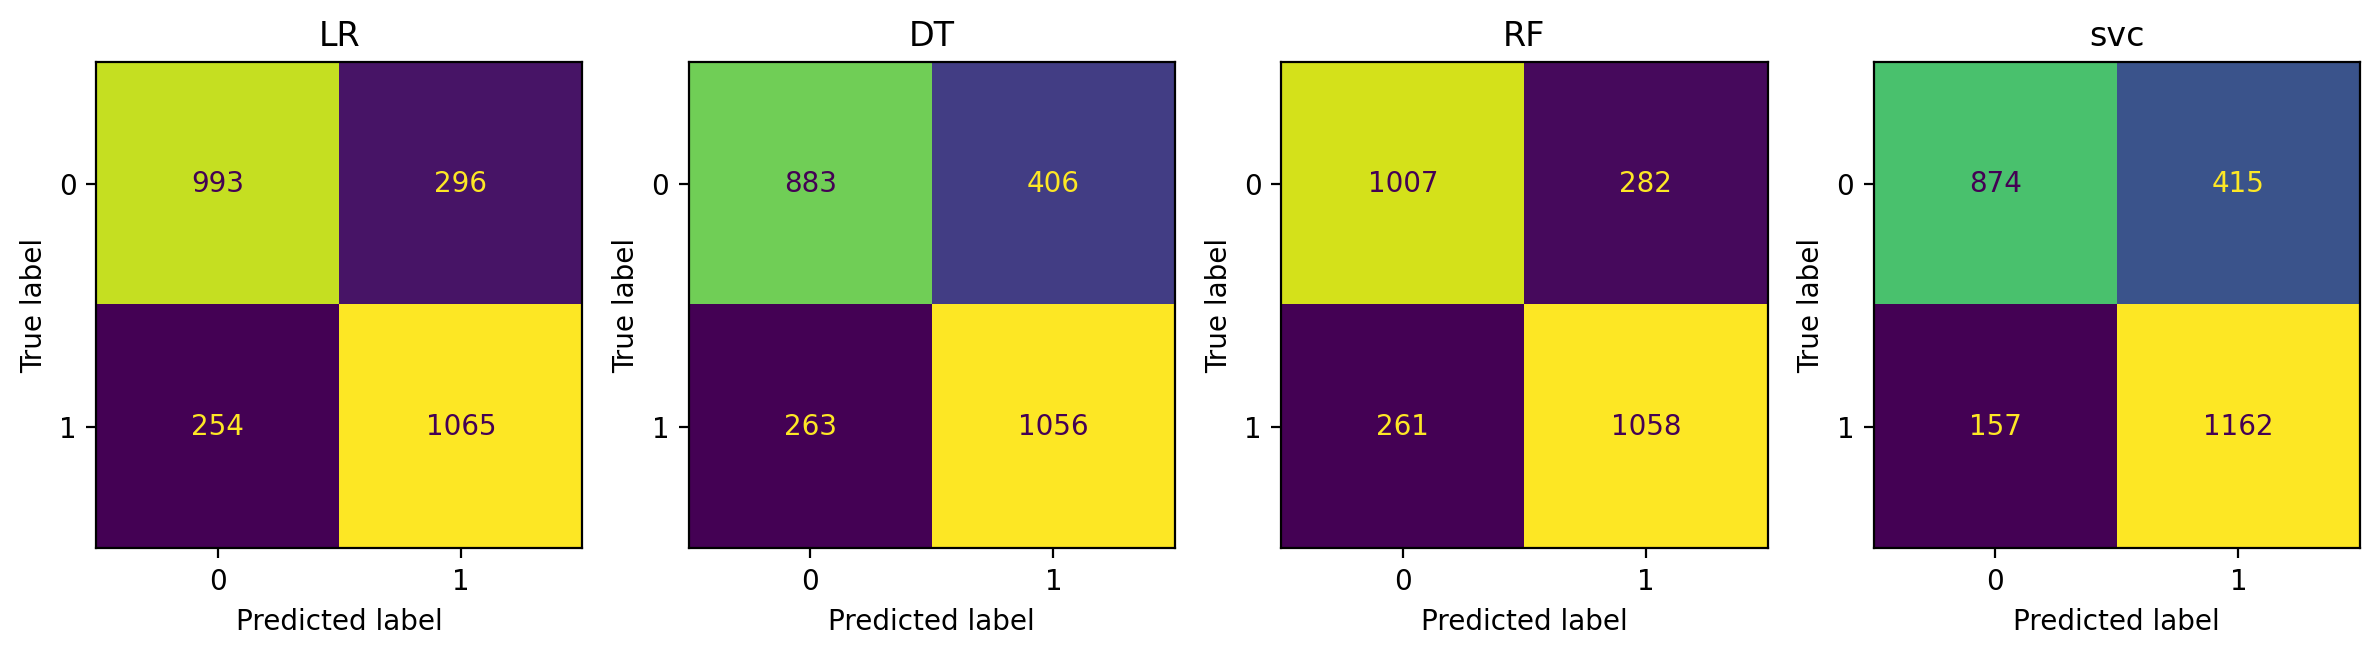

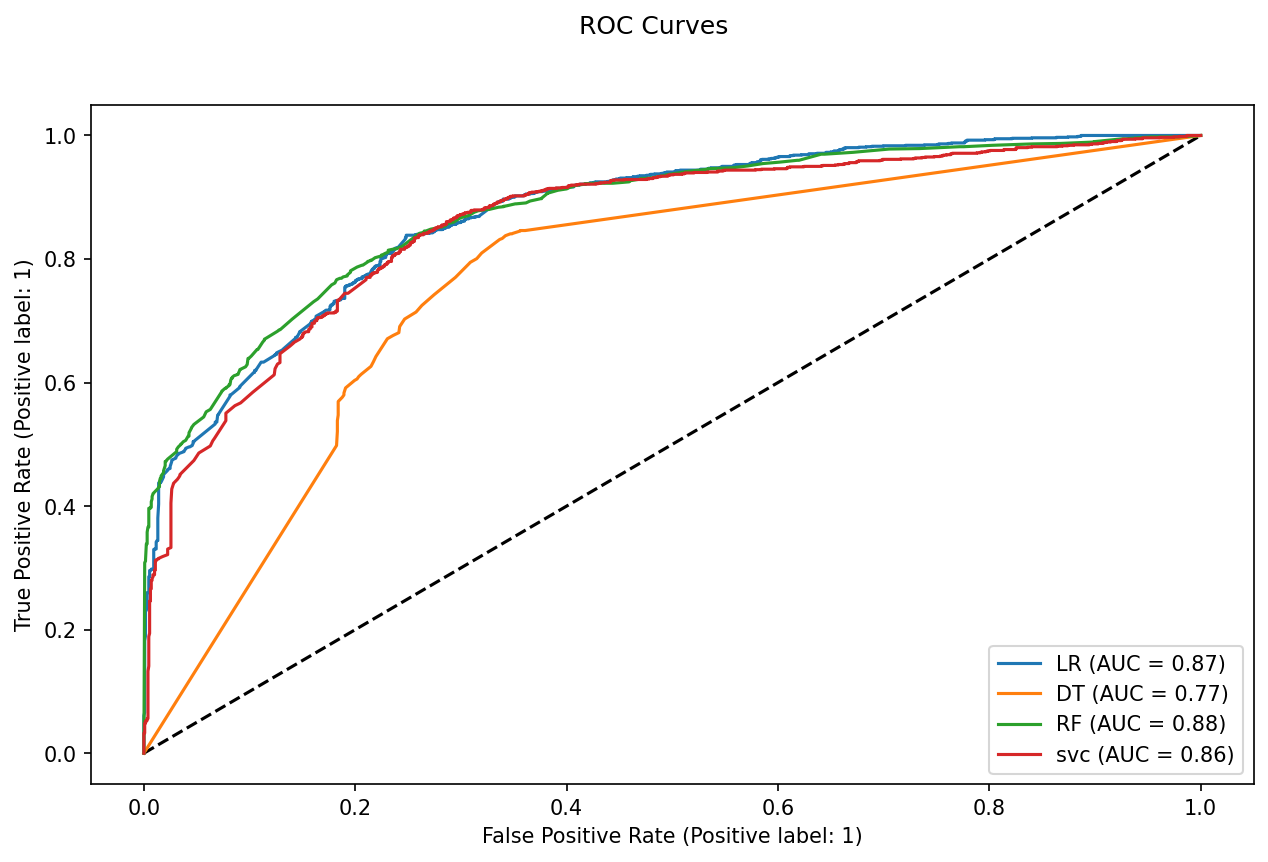

In [150]:
models = {
    'LR': LogisticRegression(penalty='l2', max_iter=10000).fit(scaled_X_train, y_train),
    'DT': DecisionTreeClassifier().fit(scaled_X_train, y_train),
    'RF': RandomForestClassifier().fit(scaled_X_train, y_train),
    'svc': SVC().fit(scaled_X_train, y_train)
}

ModelFunctions.plot_confusion_matrices(models, scaled_X_test, y_test)
ModelFunctions.classification_reports(models, scaled_X_test, y_test)
ModelFunctions.plot_roc_curves(models, scaled_X_test, y_test)